# The Wine bar project 

### Introduction & Business problem

In case my career as Data scientist fails (*let's hope it doesn't*), I want to open a wine bar in Paris, France. <br/> 
Of course wine, **I'm french !** <br/>

The problem is that, from my experience, Paris has multiple areas where people go out for a drink and these areas are not concentrated but rather spread around the city. <br/>

Therefore, where is the best location to open a new wine bar to ensure enough clients to be successful ? <br/>

To ensure success, I need the bar to be in a location where the concentration of venues such as theaters, cinemas, restaurants demonstrates an active life in the area. Using the Foursquare data, I will geolocate the venues and find the best spot to open my wine bar.

### Data section

To provide an analytical answer to the business problem of where to open my future wine bar in Paris I will do :<br/>
- A segmentation of Paris inner-city using a .geojson file : available here <a href="https://www.data.gouv.fr/fr/datasets/arrondissements-1/">data.gouv</a>
- Venues data related to the neighborhoods using Foursquare API (Category of the venue, customer rating, ...)

### Methodology

Section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

In [1]:
import pandas as pd
import numpy as np
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance
from math import sqrt

#### Loading the Paris coordinates

From a .geojson file *arrondissements.geojson* from available the French national oepn data web site <a href="https://www.data.gouv.fr/fr/datasets/arrondissements-1/">data.gouv</a> website, we will first display a map of Paris, France and place markers on the centers of each of Paris' 20 neighborhoods (*arrondissments*).

In [2]:
with open('arrondissements.geojson') as json_data:
    parisarr = json.load(json_data)
    
par_data = parisarr['features']
colnames = ['PostCode', 'Neighborhood', 'Latitude', 'Longitude']
dfparis = pd.DataFrame(columns=colnames)

We fill the DataFrame *dfparis* with data from the .geojson file.

In [3]:
for d in par_data: 
    latlon = d['properties']['geom_x_y']
    code = d['properties']['c_ar']    
    neigh = d['properties']['l_aroff']
    
    lat = latlon[0]
    lon = latlon[1]
    dfparis= dfparis.append({'PostCode' : code, 'Neighborhood' : neigh, 'Latitude' : lat, 'Longitude' : lon}, ignore_index=True)   

dfparis.head()

,PostCode,Neighborhood,Latitude,Longitude
0,3,Temple,48.862872,2.360001
1,1,Louvre,48.862563,2.336443
2,5,Panthéon,48.844443,2.350715
3,6,Luxembourg,48.849130,2.332898
4,12,Reuilly,48.834974,2.421325


In [4]:
dfparis = dfparis.sort_values(by='PostCode')

In [5]:
#Getting the coordinates of Paris to correctly center the map
address = 'Paris, France'

geolocator = Nominatim(user_agent="par_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


#### Creation of a map of Paris, using Follium

In [6]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dfparis['Latitude'], dfparis['Longitude'], dfparis['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

The above map shows Paris with the the center coordinates of its 20 arrondissements (neighborhoods).

In [7]:
df_coor = dfparis[['Latitude', 'Longitude']]
dfparis['Distance from center'] = ''

In [8]:
#Function to calculate the distance of center coordinates of each neighborgood to the center of Paris
def calc_xy_distance(coords_1, coords_2):
    return geopy.distance.vincenty(coords_1, coords_2).m

In [9]:
for i in range(0, len(df_coor)):
    dfparis['Distance from center'][i] = calc_xy_distance((df_coor['Latitude'][i], df_coor['Longitude'][i]), (latitude, longitude))

C:\Users\hantu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hantu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now let's identify the venues around each of these center coordinates of the city using the **Foursquare API**.

#### Foursquare

Let's use Foursquare API to get info on wine bars in each neighborhood.<br/>

We're interested in venues in 'Night life' category, since the density will indicate the activity of the area. Also, we are interested in areas where there is a good density of bars, nightclubs and pubs but less wine bars. We will include in out list only venues that have 'wine bar' in the category name.

In [10]:
#Foursquare Credentials
CLIENT_ID = 'JO31W52NKMLMEQBPQ3GSRBK3FKRXIIJLIFKSRNDDTC5K1Q23' # your Foursquare ID
CLIENT_SECRET = 'XVGAMH0OCJG03ALF5ONIWJN3CJ5TOMKTST0ECRVRKQVCVHNL' # your Foursquare Secret

Let's send a query to retrieve the venues using Foursquare API. To do so, we will send a query to Foursquare for each Paris' neighborhood coordinates and look for venues in the *Night life* category. <br/>

In [11]:
# Category IDs corresponding to Night life, Bars and Wine bar were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

categ_parent = '4d4b7105d754a06376d81259' #Night life
#= '4bf58dd8d48988d116941735' #Bar
categ_wine = '4bf58dd8d48988d123941735' #Wine bar category
categ_beer = '56aa371ce4b08b9a8d57356c' #Beer bar
categ_cocktail = '4bf58dd8d48988d11e941735' #Coctail bar
categ_pub = '4bf58dd8d48988d11b941735' #Pub
categ_club = '4bf58dd8d48988d11f941735' #club

In [12]:
def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', France', '')
    return address


def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

We create a dictionnary to isolate the venues which categories are most likely to be our competitors.

In [13]:
wine_bars, beer_bars, cocktail_bars, pub_bars, club_bars, other_bars = {}, {}, {}, {}, {}, {}, 
location_bars = []  

In [14]:
df2=dfparis

In [119]:
for i in range(0, len(dfparis)):
    lat = dfparis['Latitude'][i]
    lon = dfparis['Longitude'][i]
    nb_wine, nb_beer, nb_cocktail, nb_pub, nb_club, nb_other = 0, 0, 0, 0, 0, 0, 
    
    
    venues = get_venues_near_location(lat, lon, categ_parent, CLIENT_ID, CLIENT_SECRET, radius=500, limit=100)    
    area_bars = []
    
    for venue in venues:
        venue_id = venue[0]
        venue_name = venue[1]        
        venue_categories = venue[2]        
        venue_latlon = venue[3]
        venue_address = venue[4]
        venue_distance = venue[5]        
        venue_bar = (venue_id, 
                     venue_name, 
                     venue_categories[0][0], 
                     venue_latlon[0], 
                     venue_latlon[1], 
                     venue_address,            
                     dfparis.loc[i, 'Neighborhood'],
                     venue_distance)
        
        if venue_categories[0][1] == categ_wine:
            wine_bars[venue_id] = venue_bar
            nb_wine = nb_wine + 1
#         elif venue_categories[0][1] == categ_beer:
#             beer_bars[venue_id] = venue_bar
#             nb_beer = nb_beer + 1
#         elif venue_categories[0][1] == categ_cocktail:
#             cocktail_bars[venue_id] = venue_bar
#             nb_cocktail = nb_cocktail + 1
#         elif venue_categories[0][1] == categ_pub:
#             pub_bars[venue_id] = venue_bar
#             nb_pub = nb_pub + 1
#         elif venue_categories[0][1] == categ_club:
#             club_bars[venue_id] = venue_bar
#             nb_club = nb_club + 1
        else:
            other_bars[venue_id] = venue_bar
            nb_other = nb_other + 1
         
        dfparis.loc[i, 'Nb wine bars'] = nb_wine
        dfparis.loc[i, 'Nb other bars'] = nb_other

#     dfparis.loc[i, 'Nb beer bars'] = nb_beer
#     dfparis.loc[i, 'Nb cocktail bars'] = nb_cocktail
#     dfparis.loc[i, 'Nb pubs'] = nb_pub
#     dfparis.loc[i, 'Nb clubs'] = nb_club


In [120]:
dfparis.reset_index(drop=True, inplace=True)
dfparis.head()

,PostCode,Neighborhood,Latitude,Longitude,Distance from center,Nb wine bars,Nb other bars
0,1,Louvre,48.862563,2.336443,1280.59,4.0,27.0
1,2,Bourse,48.868279,2.342803,1436.21,16.0,64.0
2,3,Temple,48.862872,2.360001,929.653,6.0,33.0
3,4,Hôtel-de-Ville,48.854341,2.357630,522.961,3.0,44.0
4,5,Panthéon,48.844443,2.350715,1363.8,4.0,46.0


**Bar chart** visualization showing the number of wine bars and other bars in each neighborhood

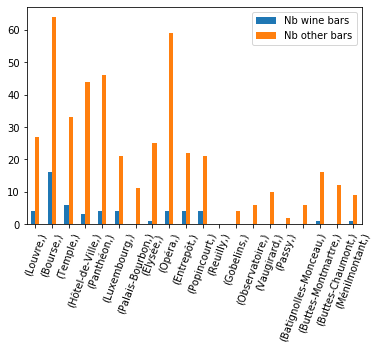

In [121]:
dfchart = dfparis[['Nb wine bars', 'Nb other bars']]
dfchart.index = dfparis[['Neighborhood']]
ax = dfchart.plot.bar(rot=70)
# ax = dfchart.plot.scatter(x='Nb wine bars', y='Nb other bars')

In [122]:
#Converting dict to pd dataFrame
df_winebars = pd.DataFrame.from_dict(wine_bars, orient='index', columns=['Id', 'Name', 'Category', 'Latitude', 'Longitude', 'Adresse', 'Neighborhood', 'Distance from center'])
df_otherbars = pd.DataFrame.from_dict(other_bars, orient='index', columns=['Id', 'Name', 'Category', 'Latitude', 'Longitude', 'Adresse', 'Neighborhood', 'Distance from center'])
df_winebars.reset_index(drop=True, inplace=True)
df_otherbars.reset_index(drop=True, inplace=True)

In [123]:
count_bars = df_otherbars[['Id', 'Category']].groupby('Category').count()

In [124]:
df_otherbars.head()

,Id,Name,Category,Latitude,Longitude,Adresse,Neighborhood,Distance from center
0,4f4e96eae4b0a99a78161d9e,Bar de l'Hôtel Jules et Jim,Hotel Bar,48.863463,2.357393,"11 rue des Gravilliers, 75003 Paris",Temple,201
1,5079f1e0e4b0eb8b83f90b0d,Little Red Door,Speakeasy,48.863703,2.363514,"60 rue Charlot, 75003 Paris",Temple,273
2,4d77b39caf63cbff3997be0f,Candelaria,Cocktail Bar,48.863032,2.364059,"56 rue de Saintonge, 75003 Paris",Temple,297
3,58e13f3babb86a218991cb2f,La Ruée Vers L'Orge,Beer Bar,48.865601,2.359647,"6 rue des Fontaines du Temple, 75003 Paris",Temple,304
4,5116b70ce4b0d096ad258d22,Le Mary Céleste,Cocktail Bar,48.861742,2.365012,"1 rue Commines (Rue Froissart), 75004 Paris",Temple,387


Let's visualize the wine bars on a Paris Map

In [125]:
# create map of Paris using latitude and longitude values
map_paris_wine = folium.Map(location=[latitude, longitude], zoom_start=12)


# add markers of wine bars to map    
for lat, lng, label in zip(df_otherbars['Latitude'], df_otherbars['Longitude'], df_otherbars['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris_wine)

# add markers of wine bars to map
for lat, lng, label in zip(df_winebars['Latitude'], df_winebars['Longitude'], df_winebars['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris_wine)  


map_paris_wine

One hot encoding

In [126]:
# one hot encoding
paris_onehot = pd.get_dummies(df_otherbars[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = df_otherbars['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
DownT_onehot = paris_onehot[fixed_columns]


print(paris_onehot.shape)
paris_onehot.head()

(759, 64)


,African Restaurant,American Restaurant,BBQ Joint,Bar,Beach Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Brasserie,...,Smoke Shop,South American Restaurant,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Tapas Restaurant,Tea Room,Vietnamese Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Temple
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Temple
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Temple
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Temple
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Temple


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [127]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped

,Neighborhood,African Restaurant,American Restaurant,BBQ Joint,Bar,Beach Bar,Beer Bar,Beer Garden,Beer Store,Bistro,...,Seafood Restaurant,Smoke Shop,South American Restaurant,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Tapas Restaurant,Tea Room,Vietnamese Restaurant
0,Batignolles-Monceau,0.000000,0.000000,0.000000,0.444444,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,Bourse,0.000000,0.012500,0.000000,0.325000,0.00,0.012500,0.000000,0.000000,0.037500,...,0.000000,0.000000,0.000000,0.000000,0.012500,0.012500,0.00000,0.000000,0.000000,0.012500
2,Buttes-Chaumont,0.000000,0.037037,0.000000,0.407407,0.00,0.074074,0.000000,0.037037,0.037037,...,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,Buttes-Montmartre,0.000000,0.000000,0.000000,0.588235,0.00,0.029412,0.029412,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.029412,0.000000,0.029412
4,Entrepôt,0.017241,0.000000,0.000000,0.396552,0.00,0.017241,0.034483,0.000000,0.034483,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.00000,0.017241,0.000000,0.000000
5,Gobelins,0.000000,0.000000,0.000000,0.666667,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,Hôtel-de-Ville,0.000000,0.000000,0.000000,0.292308,0.00,0.000000,0.030769,0.000000,0.030769,...,0.000000,0.000000,0.015385,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,Louvre,0.000000,0.000000,0.000000,0.317073,0.00,0.000000,0.048780,0.000000,0.024390,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02439,0.000000,0.000000,0.000000
8,Luxembourg,0.000000,0.000000,0.000000,0.256410,0.00,0.025641,0.025641,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.025641,0.025641,0.00000,0.000000,0.025641,0.000000
9,Ménilmontant,0.000000,0.000000,0.000000,0.529412,0.00,0.000000,0.000000,0.000000,0.117647,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [128]:
num_top_venues = 5

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Batignolles-Monceau----
               venue  freq
0                Bar  0.44
1  French Restaurant  0.22
2         Restaurant  0.11
3              Diner  0.11
4               Café  0.11


----Bourse----
               venue  freq
0                Bar  0.32
1       Cocktail Bar  0.16
2  French Restaurant  0.15
3          Nightclub  0.05
4                Pub  0.05


----Buttes-Chaumont----
          venue  freq
0           Bar  0.41
1      Beer Bar  0.07
2       Brewery  0.07
3  Cocktail Bar  0.07
4           Pub  0.04


----Buttes-Montmartre----
                   venue  freq
0                    Bar  0.59
1              Gastropub  0.09
2      French Restaurant  0.06
3  Vietnamese Restaurant  0.03
4              Nightclub  0.03


----Entrepôt----
               venue  freq
0                Bar  0.40
1  French Restaurant  0.10
2       Cocktail Bar  0.05
3             Bistro  0.03
4           Dive Bar  0.03


----Gobelins----
                venue  freq
0                 Bar  0.67
1  

In [129]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [130]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batignolles-Monceau,Bar,French Restaurant,Diner,Café,Restaurant,Vietnamese Restaurant,Coffee Shop,Comedy Club,Concert Hall,Fast Food Restaurant
1,Bourse,Bar,Cocktail Bar,French Restaurant,Nightclub,Pub,Bistro,Lounge,Gastropub,Vietnamese Restaurant,Brewery
2,Buttes-Chaumont,Bar,Beer Bar,Cocktail Bar,Brewery,Bistro,Dive Bar,American Restaurant,Gastropub,Concert Hall,Smoke Shop
3,Buttes-Montmartre,Bar,Gastropub,French Restaurant,Vietnamese Restaurant,Beer Garden,Café,Burger Joint,Lounge,Nightclub,Beer Bar
4,Entrepôt,Bar,French Restaurant,Cocktail Bar,Beer Garden,Lounge,Sports Bar,Dive Bar,Pub,Bistro,Music Venue


## Cluster Neighborhoods

### First we will evaluate the optimal number of clusters k

In [131]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [132]:
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [133]:
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(paris_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

Let's check the result using the "Elbow Method"

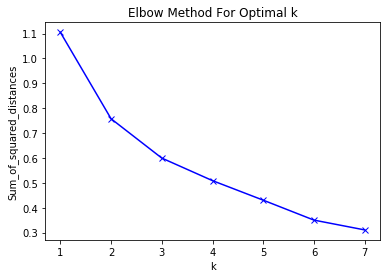

In [134]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### We can see on the above graph that the optimal k is 2, based on the elbow it forms. <br/>
Lets define *k*-means to cluster the neighborhood into 2 clusters.

In [135]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 1, 2, 1, 2, 0, 0, 1])

Merging che cluster labels with the initial Downtown Toronto dataframe

In [136]:
neighborhoods_venues_sorted= neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)

KeyError: "['Cluster Labels'] not found in axis"

In [137]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = dfparis

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

,PostCode,Neighborhood,Latitude,Longitude,Distance from center,Nb wine bars,Nb other bars,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Louvre,48.862563,2.336443,1280.59,4.0,27.0,0.0,Bar,Nightclub,French Restaurant,Hotel Bar,Lounge,Beer Garden,Pub,Café,Restaurant,Japanese Restaurant
1,2,Bourse,48.868279,2.342803,1436.21,16.0,64.0,2.0,Bar,Cocktail Bar,French Restaurant,Nightclub,Pub,Bistro,Lounge,Gastropub,Vietnamese Restaurant,Brewery
2,3,Temple,48.862872,2.360001,929.653,6.0,33.0,2.0,Bar,Cocktail Bar,French Restaurant,Gay Bar,Speakeasy,Beer Bar,Nightclub,Pub,Beer Garden,Gastropub
3,4,Hôtel-de-Ville,48.854341,2.357630,522.961,3.0,44.0,2.0,Bar,Gay Bar,French Restaurant,Cocktail Bar,Pub,Gastropub,Café,Bistro,Lounge,Beer Garden
4,5,Panthéon,48.844443,2.350715,1363.8,4.0,46.0,1.0,Bar,Pub,Café,Hookah Bar,Cocktail Bar,Lounge,Portuguese Restaurant,Brasserie,Bistro,Mexican Restaurant


Let's visualize the results on the paris map

In [138]:
paris_merged = paris_merged.dropna(subset=['Cluster Labels'])

In [139]:
paris_merged['Cluster Labels'] = paris_merged['Cluster Labels'].astype(int)

In [140]:
paris_merged

,PostCode,Neighborhood,Latitude,Longitude,Distance from center,Nb wine bars,Nb other bars,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Louvre,48.862563,2.336443,1280.59,4.0,27.0,0,Bar,Nightclub,French Restaurant,Hotel Bar,Lounge,Beer Garden,Pub,Café,Restaurant,Japanese Restaurant
1,2,Bourse,48.868279,2.342803,1436.21,16.0,64.0,2,Bar,Cocktail Bar,French Restaurant,Nightclub,Pub,Bistro,Lounge,Gastropub,Vietnamese Restaurant,Brewery
2,3,Temple,48.862872,2.360001,929.653,6.0,33.0,2,Bar,Cocktail Bar,French Restaurant,Gay Bar,Speakeasy,Beer Bar,Nightclub,Pub,Beer Garden,Gastropub
3,4,Hôtel-de-Ville,48.854341,2.357630,522.961,3.0,44.0,2,Bar,Gay Bar,French Restaurant,Cocktail Bar,Pub,Gastropub,Café,Bistro,Lounge,Beer Garden
4,5,Panthéon,48.844443,2.350715,1363.8,4.0,46.0,1,Bar,Pub,Café,Hookah Bar,Cocktail Bar,Lounge,Portuguese Restaurant,Brasserie,Bistro,Mexican Restaurant
5,6,Luxembourg,48.849130,2.332898,1601.24,4.0,21.0,0,Bar,Pub,Café,Nightclub,Cocktail Bar,French Restaurant,Tea Room,Fast Food Restaurant,Jazz Club,Modern European Restaurant
6,7,Palais-Bourbon,48.856174,2.312188,2882.58,0.0,11.0,2,French Restaurant,Bar,Cocktail Bar,Sports Bar,American Restaurant,Spanish Restaurant,Coffee Shop,Hotel,Café,Gay Bar
7,8,Élysée,48.872721,2.312554,3365.18,1.0,25.0,0,Nightclub,French Restaurant,Bar,Pub,Cocktail Bar,Hotel Bar,Hookah Bar,Lounge,Restaurant,Brewery
8,9,Opéra,48.877164,2.337458,2497.19,4.0,59.0,2,Bar,Cocktail Bar,French Restaurant,Lounge,Pub,Nightclub,Karaoke Bar,Bistro,Dive Bar,Cheese Shop
9,10,Entrepôt,48.876130,2.360728,2265.53,4.0,22.0,2,Bar,French Restaurant,Cocktail Bar,Beer Garden,Lounge,Sports Bar,Dive Bar,Pub,Bistro,Music Venue


In [141]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers of wine bars to map
for lat, lng, label in zip(df_winebars['Latitude'], df_winebars['Longitude'], df_winebars['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6.5,
        popup=label,
        color='light green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_clusters)  



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [142]:
paris_merged.head()

,PostCode,Neighborhood,Latitude,Longitude,Distance from center,Nb wine bars,Nb other bars,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Louvre,48.862563,2.336443,1280.59,4.0,27.0,0,Bar,Nightclub,French Restaurant,Hotel Bar,Lounge,Beer Garden,Pub,Café,Restaurant,Japanese Restaurant
1,2,Bourse,48.868279,2.342803,1436.21,16.0,64.0,2,Bar,Cocktail Bar,French Restaurant,Nightclub,Pub,Bistro,Lounge,Gastropub,Vietnamese Restaurant,Brewery
2,3,Temple,48.862872,2.360001,929.653,6.0,33.0,2,Bar,Cocktail Bar,French Restaurant,Gay Bar,Speakeasy,Beer Bar,Nightclub,Pub,Beer Garden,Gastropub
3,4,Hôtel-de-Ville,48.854341,2.357630,522.961,3.0,44.0,2,Bar,Gay Bar,French Restaurant,Cocktail Bar,Pub,Gastropub,Café,Bistro,Lounge,Beer Garden
4,5,Panthéon,48.844443,2.350715,1363.8,4.0,46.0,1,Bar,Pub,Café,Hookah Bar,Cocktail Bar,Lounge,Portuguese Restaurant,Brasserie,Bistro,Mexican Restaurant


In [180]:
mychart = paris_merged[['Cluster Labels', '1st Most Common Venue', 'Nb wine bars']]
print(mychart)
mychart = mychart.groupby(['Cluster Labels', '1st Most Common Venue']).agg({'1st Most Common Venue': 'count', 'Nb wine bars': 'sum'})
mychart

    Cluster Labels 1st Most Common Venue  Nb wine bars
0                0                   Bar           4.0
1                2                   Bar          16.0
2                2                   Bar           6.0
3                2                   Bar           3.0
4                1                   Bar           4.0
5                0                   Bar           4.0
6                2     French Restaurant           0.0
7                0             Nightclub           1.0
8                2                   Bar           4.0
9                2                   Bar           4.0
10               2                   Bar           4.0
12               1                   Bar           0.0
13               1                   Bar           0.0
14               0            Sports Bar           0.0
15               0     French Restaurant           0.0
16               1                   Bar           0.0
17               1                   Bar           1.0
18        

1st Most Common Venue  Nb wine bars
Cluster Labels 1st Most Common Venue                                     
0              Bar                                        2           8.0
               French Restaurant                          1           0.0
               Nightclub                                  1           1.0
               Sports Bar                                 1           0.0
1              Bar                                        6           6.0
2              Bar                                        7          37.0
               French Restaurant                          1           0.0

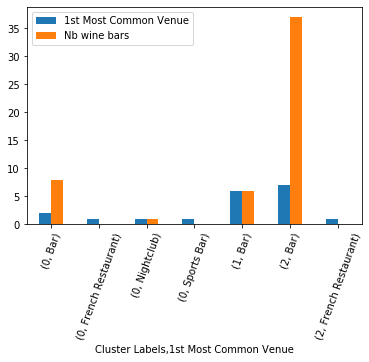

In [181]:
ax = mychart.plot.bar(rot=70)

In [182]:
print(parisarr)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[2.363828096062925, 48.86750443060333], [2.363889283103472, 48.86746799613759], [2.363895272057997, 48.86746439462841], [2.36390615161445, 48.86745794031929], [2.3639604108556, 48.86742562395425], [2.364050888403437, 48.86737182228858], [2.364136202212002, 48.86732090069028], [2.364196150694383, 48.86728527518643], [2.364231046057404, 48.867264504998545], [2.3642488892099323, 48.8672538841255], [2.364262374754115, 48.867231487510104], [2.364317526957068, 48.8671399217101], [2.364378833526726, 48.86703799037503], [2.364437745426764, 48.86694013469137], [2.36445371308141, 48.86691372487684], [2.364489529577707, 48.86685418348327], [2.364499215217103, 48.86683808273435], [2.364499503250018, 48.86683760311589], [2.364517178379751, 48.866808221039065], [2.364544549216028, 48.86676280301149], [2.364674522150413, 48.86654659693744], [2.364735520441731, 48.86644512599779], [2.3647512

In [183]:
map_clusters.choropleth(
    geo_data='arrondissements.geojson',
    data = paris_merged,
    columns=['Neighborhood', 'Nb wine bars'], 
    key_on='feature.properties.l_aroff',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
)

map_clusters

C:\Users\hantu\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Questions : Faut il mettre tous les résultats des venues dans un seul dataframe ? <br/>

Idée : suivre le projet précédent capstone sur toronto puis par l'analyse exploratoire identifier les quartiers où l'on a un concentration des bars à vins. Vérifier grâce à K-mean dans ces quartiers les types de venues populaires. Enfin voir dans quels quartiers on retrouve des clusters similaires avec moins de bars à vin. Ces quartiers seront des candidats intéressants.

### Results

### Discussion

### Conclusion